In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from numpy import sqrt
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
%%time
df = pd.read_excel('indeed_results_pp_2020-04-27.xlsx')

Wall time: 48.3 s


In [3]:
s = df[(df['Title_New'] == 'full stack developer') & (df['Salary_Average'] != 0) & ((df['Education_Tenth'] == 1) | (df['Education_Twelvth'] == 1) | (df['Education_Bachelors'] == 1) | (df['Education_Masters'] == 1) | (df['Education_Doctorate'] == 1))][['Title_New', 'Monthly_Salary', 'Education_Tenth', 'Education_Twelvth', 'Education_Bachelors', 'Education_Masters', 'Education_Doctorate', 'XP_Experience', 'XP_Fresher']].reset_index().drop(['index'], axis=1) # (s['XP_Experience'] == 1) | (s['XP_Fresher'] == 1)

In [4]:
cat_cols = ['Education_Tenth', 'Education_Twelvth', 'Education_Bachelors', 'Education_Masters', 'Education_Doctorate']
cont_cols = []
y_col = ['Monthly_Salary']

In [5]:
cats = np.stack([s[col] for col in cat_cols], axis=1)
cats = torch.tensor(cats, dtype=torch.int64)
cats[:4]

tensor([[0, 0, 1, 0, 0],
        [0, 0, 1, 1, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0]])

In [6]:
y = torch.tensor(s[y_col].values, dtype=torch.float).flatten()

In [7]:
y.shape

torch.Size([181])

In [8]:
y = y.reshape(-1, 1)

In [9]:
cats.shape

torch.Size([181, 5])

In [10]:
cat_szs = [len(df[col]) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(90700, 50), (90700, 50), (90700, 50), (90700, 50), (90700, 50)]

In [11]:
catz = cats[:4]
catz

tensor([[0, 0, 1, 0, 0],
        [0, 0, 1, 1, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0]])

In [12]:
selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
selfembeds

ModuleList(
  (0): Embedding(90700, 50)
  (1): Embedding(90700, 50)
  (2): Embedding(90700, 50)
  (3): Embedding(90700, 50)
  (4): Embedding(90700, 50)
)

In [13]:
list(enumerate(selfembeds))

[(0, Embedding(90700, 50)),
 (1, Embedding(90700, 50)),
 (2, Embedding(90700, 50)),
 (3, Embedding(90700, 50)),
 (4, Embedding(90700, 50))]

In [14]:
embeddingz = []
for i,e in enumerate(selfembeds):
    embeddingz.append(e(catz[:,i]))
embeddingz

[tensor([[ 0.8624,  1.1025,  0.6701,  1.3275, -1.5066,  1.5538,  0.9284, -0.2682,
          -0.5525,  0.5310, -0.8351,  0.3726,  0.7351,  0.1382, -0.9121,  0.4569,
          -0.8349, -0.4668, -0.8518, -1.3899, -0.9088, -0.4535, -1.2431, -2.2033,
          -1.7809, -0.1963, -0.9194, -0.1687, -0.8382, -1.1632,  2.6462,  1.3160,
           1.1053, -0.5042,  0.4753, -1.3136, -2.0654, -1.4246,  0.5547,  0.4590,
           0.6434,  0.0238,  1.8405, -0.2645,  0.2400, -0.2830, -0.2322,  0.3005,
           0.6001,  0.7704],
         [ 0.8624,  1.1025,  0.6701,  1.3275, -1.5066,  1.5538,  0.9284, -0.2682,
          -0.5525,  0.5310, -0.8351,  0.3726,  0.7351,  0.1382, -0.9121,  0.4569,
          -0.8349, -0.4668, -0.8518, -1.3899, -0.9088, -0.4535, -1.2431, -2.2033,
          -1.7809, -0.1963, -0.9194, -0.1687, -0.8382, -1.1632,  2.6462,  1.3160,
           1.1053, -0.5042,  0.4753, -1.3136, -2.0654, -1.4246,  0.5547,  0.4590,
           0.6434,  0.0238,  1.8405, -0.2645,  0.2400, -0.2830, -0.23

In [15]:
z = torch.cat(embeddingz, 1)
z

tensor([[ 8.6242e-01,  1.1025e+00,  6.7009e-01,  1.3275e+00, -1.5066e+00,
          1.5538e+00,  9.2837e-01, -2.6822e-01, -5.5246e-01,  5.3104e-01,
         -8.3514e-01,  3.7263e-01,  7.3509e-01,  1.3816e-01, -9.1212e-01,
          4.5694e-01, -8.3488e-01, -4.6679e-01, -8.5184e-01, -1.3899e+00,
         -9.0885e-01, -4.5352e-01, -1.2431e+00, -2.2033e+00, -1.7809e+00,
         -1.9635e-01, -9.1943e-01, -1.6866e-01, -8.3817e-01, -1.1632e+00,
          2.6462e+00,  1.3160e+00,  1.1053e+00, -5.0416e-01,  4.7530e-01,
         -1.3136e+00, -2.0654e+00, -1.4246e+00,  5.5474e-01,  4.5902e-01,
          6.4337e-01,  2.3816e-02,  1.8405e+00, -2.6448e-01,  2.3998e-01,
         -2.8298e-01, -2.3221e-01,  3.0053e-01,  6.0012e-01,  7.7037e-01,
         -1.1977e+00, -7.8754e-01, -1.1339e+00, -4.3108e-01,  7.7442e-01,
          1.2292e+00,  9.7176e-02,  3.2851e-01,  8.1373e-01, -8.3381e-01,
          8.4776e-01,  8.1510e-02, -9.8397e-02, -1.4107e+00, -7.5049e-01,
         -2.6582e+00, -3.2428e-01, -1.

In [16]:
selfembdrop = nn.Dropout(.4)

In [17]:
z = selfembdrop(z)
z

tensor([[ 0.0000e+00,  1.8375e+00,  1.1168e+00,  2.2125e+00, -2.5110e+00,
          2.5896e+00,  1.5473e+00, -0.0000e+00, -0.0000e+00,  8.8507e-01,
         -0.0000e+00,  6.2104e-01,  1.2252e+00,  2.3027e-01, -0.0000e+00,
          0.0000e+00, -1.3915e+00, -0.0000e+00, -0.0000e+00, -2.3166e+00,
         -1.5147e+00, -7.5586e-01, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -3.2725e-01, -0.0000e+00, -2.8109e-01, -1.3969e+00, -1.9387e+00,
          0.0000e+00,  2.1933e+00,  1.8421e+00, -8.4027e-01,  7.9217e-01,
         -2.1894e+00, -3.4424e+00, -2.3744e+00,  9.2456e-01,  0.0000e+00,
          1.0723e+00,  3.9694e-02,  0.0000e+00, -0.0000e+00,  3.9996e-01,
         -4.7163e-01, -0.0000e+00,  0.0000e+00,  1.0002e+00,  1.2839e+00,
         -1.9962e+00, -1.3126e+00, -0.0000e+00, -7.1847e-01,  0.0000e+00,
          2.0487e+00,  0.0000e+00,  0.0000e+00,  1.3562e+00, -1.3897e+00,
          1.4129e+00,  0.0000e+00, -1.6399e-01, -2.3512e+00, -1.2508e+00,
         -0.0000e+00, -0.0000e+00, -0.

In [18]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x = torch.cat([x], 1)
        x = self.layers(x)
        return x

In [19]:
torch.manual_seed(33)
model = TabularModel(emb_szs, 1, [200, 100, 50, 25, 50, 100, 200], p=0.4)

In [20]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(90700, 50)
    (1): Embedding(90700, 50)
    (2): Embedding(90700, 50)
    (3): Embedding(90700, 50)
    (4): Embedding(90700, 50)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=250, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [21]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
epochs = 5000
losses = []

for i in range(epochs):
    y_pred = model(cats)
    loss = torch.sqrt(criterion(y_pred, y))
    losses.append(loss)
    
    if (i+1)%500 == 0:
        print(f'epoch: {(i+1):3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch: 100  loss: 59944.92578125
epoch: 200  loss: 59936.35156250
epoch: 300  loss: 59922.27734375
epoch: 400  loss: 59904.70703125
epoch: 500  loss: 59879.20703125
epoch: 600  loss: 59849.47265625
epoch: 700  loss: 59814.61718750
epoch: 800  loss: 59775.45312500
epoch: 900  loss: 59731.24609375
epoch: 1000  loss: 59676.69531250
epoch: 1100  loss: 59630.60156250
epoch: 1200  loss: 59580.51171875
epoch: 1300  loss: 59520.62500000
epoch: 1400  loss: 59454.16015625
epoch: 1500  loss: 59394.42187500
epoch: 1600  loss: 59297.93359375
epoch: 1700  loss: 59234.43359375
epoch: 1800  loss: 59145.12500000
epoch: 1900  loss: 59073.92968750
epoch: 2000  loss: 58990.85546875
epoch: 2100  loss: 58900.32421875
epoch: 2200  loss: 58824.76562500
epoch: 2300  loss: 58724.08593750
epoch: 2400  loss: 58623.19531250
epoch: 2500  loss: 58535.92187500
epoch: 2600  loss: 58455.82031250
epoch: 2700  loss: 58257.54687500
epoch: 2800  loss: 58189.28515625
epoch: 2900  loss: 58108.50390625
epoch: 3000  loss: 5799

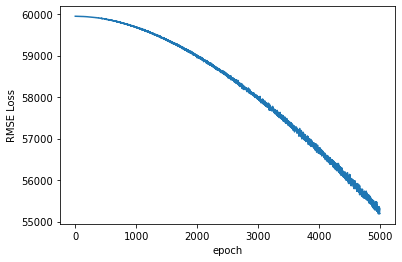

In [23]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

In [24]:
with torch.no_grad():
    y_val = model(cats)
    loss = torch.sqrt(criterion(y_val, y))
print(f'RMSE: {loss:.8f}')

RMSE: 55293.26562500


In [25]:
(torch.sqrt(criterion(y_val, y)) / y).mean()

tensor(1.8269)